In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
torch.__version__
import numpy as np
from plot import plot_loss_and_acc

In [37]:
# 超参数
BATCH_SIZE=512 #大概需要2G的显存
EPOCHS=10 # 总共训练批次
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 让torch判断是否使用GPU，建议使用GPU环境，因为会快很多
print(DEVICE)

cpu


In [38]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True, 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

In [39]:
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

In [40]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # batch*1*28*28（每次会送入batch个样本，输入通道数1（黑白图像），图像分辨率是28x28）
        # 下面的卷积层Conv2d的第一个参数指输入通道数，第二个参数指输出通道数，第三个参数指卷积核的大小
        self.conv1 = nn.Conv2d(1, 10, 5) # 输入通道数1，输出通道数10，核的大小5
        self.conv2 = nn.Conv2d(10, 20, 3) # 输入通道数10，输出通道数20，核的大小3
        # 下面的全连接层Linear的第一个参数指输入通道数，第二个参数指输出通道数
        self.fc1 = nn.Linear(20*10*10, 500) # 输入通道数是2000，输出通道数是500
        self.fc2 = nn.Linear(500, 10) # 输入通道数是500，输出通道数是10，即10分类
    def forward(self,x):
        in_size = x.size(0) # 在本例中in_size=512，也就是BATCH_SIZE的值。输入的x可以看成是512*1*28*28的张量。
        out = self.conv1(x) # batch*1*28*28 -> batch*10*24*24（28x28的图像经过一次核为5x5的卷积，输出变为24x24）
        out = F.relu(out) # batch*10*24*24（激活函数ReLU不改变形状））
        out = F.max_pool2d(out, 2, 2) # batch*10*24*24 -> batch*10*12*12（2*2的池化层会减半）
        out = self.conv2(out) # batch*10*12*12 -> batch*20*10*10（再卷积一次，核的大小是3）
        out = F.relu(out) # batch*20*10*10
        out = out.view(in_size, -1) # batch*20*10*10 -> batch*2000（out的第二维是-1，说明是自动推算，本例中第二维是20*10*10）
        out = self.fc1(out) # batch*2000 -> batch*500
        out = F.relu(out) # batch*500
        out = self.fc2(out) # batch*500 -> batch*10
        out = F.log_softmax(out, dim=1) # 计算log(softmax(x))
        return out

In [41]:
class MLPNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 392)
        self.fc2 = nn.Linear(392,128)
        self.fc3 = nn.Linear(128,10)
    def forward(self, x):
        in_size = x.size(0)
        out = x.view(in_size, -1)
        out = self.fc1(out)
        out =  F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)
        return out

In [70]:
def train_one_epoch(model, device, train_loader, optimizer, epoch):
    batch_train_loss, batch_train_acc = [], []
    model.train()
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.max(1, keepdim=True)[1] # 找到概率最大的下标
        _, predicted = torch.max(output, 1)
        corr = (predicted == target).sum().item()
        loss.backward()
        optimizer.step()
        correct += corr
        total += target.size(0)

        if(batch_idx+1)%30 == 0: 
            acc = 1.000 * correct/total
            # print('correct:',correct, 'total:', total , 'acc:', acc)
            batch_train_acc.append(acc)
            batch_train_loss.append(loss.item())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tACC: {:.6f}'.format(
                epoch, total, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), acc))
    return batch_train_loss, batch_train_acc

def train(model, device, train_loader, optimizer, epoch):
    avg_batch_train_loss, avg_batch_train_acc = [], []
    for ep in range(1, epoch + 1):
        batch_train_loss,batch_train_acc = train_one_epoch(model, device, train_loader, optimizer, ep)
        avg_batch_train_loss.append(np.mean(batch_train_loss))
        avg_batch_train_acc.append(np.mean(batch_train_acc))
    return model, avg_batch_train_loss, avg_batch_train_acc

In [71]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # 将一批的损失相加
            pred = output.max(1, keepdim=True)[1] # 找到概率最大的下标
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [72]:
# CNN 模型
cnn_model = ConvNet().to(DEVICE)
optimizer = optim.Adam(cnn_model.parameters())

In [73]:
# 训练CNN模型
cnn_model, cnn_loss, cnn_acc = train(cnn_model, DEVICE, train_loader, optimizer, EPOCHS)
test(cnn_model, DEVICE, test_loader)

Train Epoch: 1 [15360/60000 (25%)]	Loss: 0.269838	ACC: 0.802539
Train Epoch: 1 [30720/60000 (50%)]	Loss: 0.201269	ACC: 0.867025
Train Epoch: 1 [46080/60000 (75%)]	Loss: 0.084885	ACC: 0.897526
Train Epoch: 2 [15360/60000 (25%)]	Loss: 0.110589	ACC: 0.973047
Train Epoch: 2 [30720/60000 (50%)]	Loss: 0.079302	ACC: 0.975000
Train Epoch: 2 [46080/60000 (75%)]	Loss: 0.071191	ACC: 0.976302
Train Epoch: 3 [15360/60000 (25%)]	Loss: 0.069422	ACC: 0.982747
Train Epoch: 3 [30720/60000 (50%)]	Loss: 0.059374	ACC: 0.982943
Train Epoch: 3 [46080/60000 (75%)]	Loss: 0.052730	ACC: 0.983963
Train Epoch: 4 [15360/60000 (25%)]	Loss: 0.081130	ACC: 0.986393
Train Epoch: 4 [30720/60000 (50%)]	Loss: 0.027947	ACC: 0.986458
Train Epoch: 4 [46080/60000 (75%)]	Loss: 0.037792	ACC: 0.987218
Train Epoch: 5 [15360/60000 (25%)]	Loss: 0.011851	ACC: 0.990234
Train Epoch: 5 [30720/60000 (50%)]	Loss: 0.046851	ACC: 0.990332
Train Epoch: 5 [46080/60000 (75%)]	Loss: 0.019808	ACC: 0.990299
Train Epoch: 6 [15360/60000 (25%)]	Loss:

In [74]:
# MLP 模型
mlp_model = MLPNet().to(DEVICE)
mlp_optimizer = optim.Adam(mlp_model.parameters())

In [75]:
# 训练MLP模型
mlp_model, mlp_loss, mlp_acc = train(mlp_model, DEVICE, train_loader, mlp_optimizer, EPOCHS)
test(mlp_model, DEVICE, test_loader)

Train Epoch: 1 [15360/60000 (25%)]	Loss: 0.383950	ACC: 0.787044
Train Epoch: 1 [30720/60000 (50%)]	Loss: 0.371262	ACC: 0.846810
Train Epoch: 1 [46080/60000 (75%)]	Loss: 0.227287	ACC: 0.873611
Train Epoch: 2 [15360/60000 (25%)]	Loss: 0.094946	ACC: 0.951172
Train Epoch: 2 [30720/60000 (50%)]	Loss: 0.114726	ACC: 0.953841
Train Epoch: 2 [46080/60000 (75%)]	Loss: 0.155955	ACC: 0.954470
Train Epoch: 3 [15360/60000 (25%)]	Loss: 0.096198	ACC: 0.968294
Train Epoch: 3 [30720/60000 (50%)]	Loss: 0.099558	ACC: 0.969173
Train Epoch: 3 [46080/60000 (75%)]	Loss: 0.056993	ACC: 0.969835
Train Epoch: 4 [15360/60000 (25%)]	Loss: 0.096281	ACC: 0.979753
Train Epoch: 4 [30720/60000 (50%)]	Loss: 0.099552	ACC: 0.980046
Train Epoch: 4 [46080/60000 (75%)]	Loss: 0.069461	ACC: 0.979753
Train Epoch: 5 [15360/60000 (25%)]	Loss: 0.059871	ACC: 0.984766
Train Epoch: 5 [30720/60000 (50%)]	Loss: 0.058813	ACC: 0.984635
Train Epoch: 5 [46080/60000 (75%)]	Loss: 0.063411	ACC: 0.983637
Train Epoch: 6 [15360/60000 (25%)]	Loss:

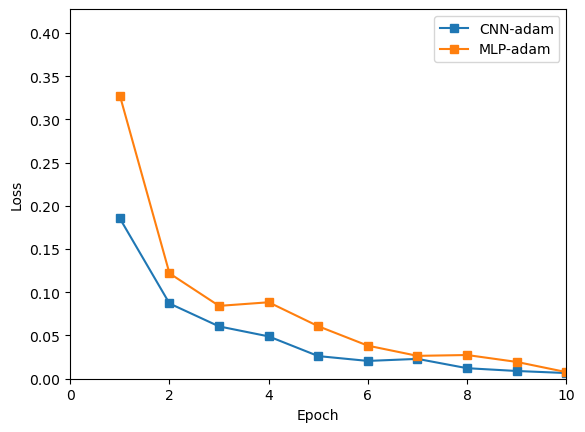

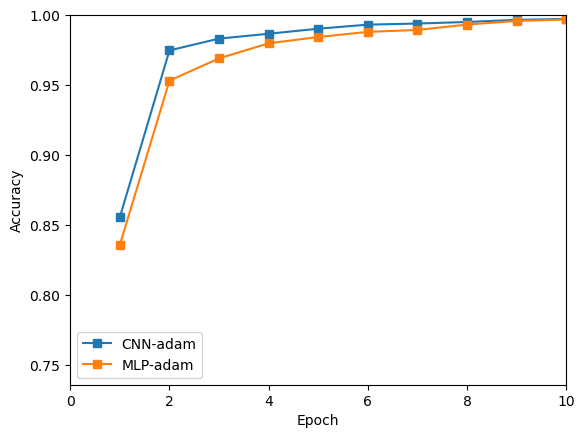

In [76]:
plot_loss_and_acc({'CNN-adam': [cnn_loss, cnn_acc],
                   'MLP-adam': [mlp_loss, mlp_acc]})

In [77]:
# 超参数
learning_rate = 0.1
momentum = 0.9


In [78]:
# 一个卷积层，一个pooling，两个全连接层
class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        # batch*1*28*28（每次会送入batch个样本，输入通道数1（黑白图像），图像分辨率是28x28）
        # 下面的卷积层Conv2d的第一个参数指输入通道数，第二个参数指输出通道数，第三个参数指卷积核的大小
        self.conv1 = nn.Conv2d(1, 10, 5) # 输入通道数1，输出通道数10，核的大小5
        # 下面的全连接层Linear的第一个参数指输入通道数，第二个参数指输出通道数
        self.fc1 = nn.Linear(10*12*12, 500) # 输入通道数是1440，输出通道数是500
        self.fc2 = nn.Linear(500, 10) # 输入通道数是500，输出通道数是10，即10分类
    def forward(self,x):
        in_size = x.size(0) # 在本例中in_size=512，也就是BATCH_SIZE的值。输入的x可以看成是512*1*28*28的张量。
        out = self.conv1(x) # batch*1*28*28 -> batch*10*24*24（28x28的图像经过一次核为5x5的卷积，输出变为24x24）
        out = F.relu(out) # batch*10*24*24（激活函数ReLU不改变形状））
        out = F.max_pool2d(out, 2, 2) # batch*10*24*24 -> batch*10*12*12（2*2的池化层会减半）
        out = out.view(in_size, -1) # batch*10*12*12 -> batch*1440（out的第二维是-1，说明是自动推算，本例中第二维是10*12*12）
        out = self.fc1(out) # batch*1440 -> batch*500
        out = F.relu(out) # batch*500
        out = self.fc2(out) # batch*500 -> batch*10
        out = F.log_softmax(out, dim=1) # 计算log(softmax(x))
        return out

In [79]:
# 一个卷积层，一个pooling，两个全连接层
# CNN 模型
cnn_model2 = ConvNet2().to(DEVICE)
optimizer2 = optim.Adam(cnn_model2.parameters())
cnn_model2, cnn_loss2, cnn_acc2 = train(cnn_model2, DEVICE, train_loader, optimizer2, EPOCHS)
test(cnn_model2, DEVICE, test_loader)

Train Epoch: 1 [15360/60000 (25%)]	Loss: 0.310937	ACC: 0.800846
Train Epoch: 1 [30720/60000 (50%)]	Loss: 0.232085	ACC: 0.859310
Train Epoch: 1 [46080/60000 (75%)]	Loss: 0.181231	ACC: 0.887609
Train Epoch: 2 [15360/60000 (25%)]	Loss: 0.092699	ACC: 0.961328
Train Epoch: 2 [30720/60000 (50%)]	Loss: 0.070028	ACC: 0.965625
Train Epoch: 2 [46080/60000 (75%)]	Loss: 0.073978	ACC: 0.967773
Train Epoch: 3 [15360/60000 (25%)]	Loss: 0.056886	ACC: 0.979232
Train Epoch: 3 [30720/60000 (50%)]	Loss: 0.060187	ACC: 0.980013
Train Epoch: 3 [46080/60000 (75%)]	Loss: 0.073885	ACC: 0.980360
Train Epoch: 4 [15360/60000 (25%)]	Loss: 0.027742	ACC: 0.986458
Train Epoch: 4 [30720/60000 (50%)]	Loss: 0.041216	ACC: 0.985449
Train Epoch: 4 [46080/60000 (75%)]	Loss: 0.075664	ACC: 0.985764
Train Epoch: 5 [15360/60000 (25%)]	Loss: 0.053079	ACC: 0.989909
Train Epoch: 5 [30720/60000 (50%)]	Loss: 0.040486	ACC: 0.989258
Train Epoch: 5 [46080/60000 (75%)]	Loss: 0.038125	ACC: 0.989041
Train Epoch: 6 [15360/60000 (25%)]	Loss:

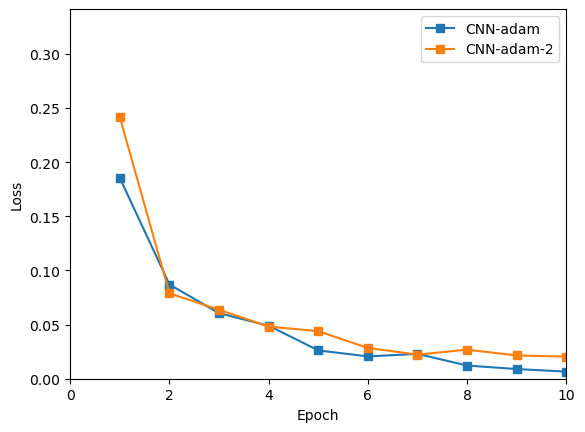

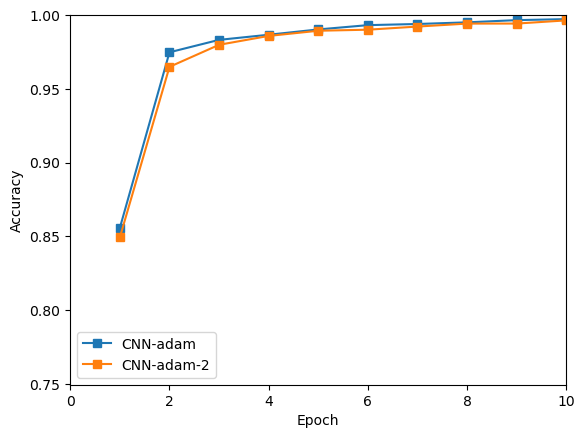

In [80]:
plot_loss_and_acc({'CNN-adam': [cnn_loss, cnn_acc],
                   'CNN-adam-2': [cnn_loss2, cnn_acc2]})

In [81]:
# ConvNet2 的卷积核变大， 变为 7*7
class ConvNet3(nn.Module):
    def __init__(self):
        super().__init__()
        # batch*1*28*28（每次会送入batch个样本，输入通道数1（黑白图像），图像分辨率是28x28）
        # 下面的卷积层Conv2d的第一个参数指输入通道数，第二个参数指输出通道数，第三个参数指卷积核的大小
        self.conv1 = nn.Conv2d(1, 10, 7) # 输入通道数1，输出通道数10，核的大小7
        # 下面的全连接层Linear的第一个参数指输入通道数，第二个参数指输出通道数
        self.fc1 = nn.Linear(10*11*11, 500) # 输入通道数是1210，输出通道数是500
        self.fc2 = nn.Linear(500, 10) # 输入通道数是500，输出通道数是10，即10分类
    def forward(self,x):
        in_size = x.size(0) # 在本例中in_size=512，也就是BATCH_SIZE的值。输入的x可以看成是512*1*28*28的张量。
        out = self.conv1(x) # batch*1*28*28 -> batch*10*22*22（28x28的图像经过一次核为7x7的卷积，输出变为22x22）
        out = F.relu(out) # batch*10*22*22（激活函数ReLU不改变形状））
        out = F.max_pool2d(out, 2, 2) # batch*10*22*22 -> batch*10*11*11（2*2的池化层会减半）
        out = out.view(in_size, -1) # batch*10*11*11 -> batch*1210（out的第二维是-1，说明是自动推算，本例中第二维是10*11*11）
        out = self.fc1(out) # batch*1210 -> batch*500
        out = F.relu(out) # batch*500
        out = self.fc2(out) # batch*500 -> batch*10
        out = F.log_softmax(out, dim=1) # 计算log(softmax(x))
        return out

In [82]:
# 一个卷积层， 卷积核变大，一个pooling，两个全连接层
# CNN 模型
cnn_model3 = ConvNet3().to(DEVICE)
optimizer3 = optim.Adam(cnn_model3.parameters())
cnn_model3, cnn_loss3, cnn_acc3 = train(cnn_model3, DEVICE, train_loader, optimizer3, EPOCHS)
test(cnn_model3, DEVICE, test_loader)

Train Epoch: 1 [15360/60000 (25%)]	Loss: 0.255820	ACC: 0.820443
Train Epoch: 1 [30720/60000 (50%)]	Loss: 0.130830	ACC: 0.878060
Train Epoch: 1 [46080/60000 (75%)]	Loss: 0.127486	ACC: 0.903168
Train Epoch: 2 [15360/60000 (25%)]	Loss: 0.073223	ACC: 0.972982
Train Epoch: 2 [30720/60000 (50%)]	Loss: 0.099863	ACC: 0.973079
Train Epoch: 2 [46080/60000 (75%)]	Loss: 0.059183	ACC: 0.974523
Train Epoch: 3 [15360/60000 (25%)]	Loss: 0.054068	ACC: 0.983464
Train Epoch: 3 [30720/60000 (50%)]	Loss: 0.041611	ACC: 0.984017
Train Epoch: 3 [46080/60000 (75%)]	Loss: 0.057965	ACC: 0.983377
Train Epoch: 4 [15360/60000 (25%)]	Loss: 0.069206	ACC: 0.986523
Train Epoch: 4 [30720/60000 (50%)]	Loss: 0.033553	ACC: 0.987077
Train Epoch: 4 [46080/60000 (75%)]	Loss: 0.034402	ACC: 0.986589
Train Epoch: 5 [15360/60000 (25%)]	Loss: 0.022972	ACC: 0.989453
Train Epoch: 5 [30720/60000 (50%)]	Loss: 0.023103	ACC: 0.989811
Train Epoch: 5 [46080/60000 (75%)]	Loss: 0.014311	ACC: 0.989627
Train Epoch: 6 [15360/60000 (25%)]	Loss:

In [83]:
# ConvNet4 的卷积核变小， 变为 3*3
class ConvNet4(nn.Module):
    def __init__(self):
        super().__init__()
        # batch*1*28*28（每次会送入batch个样本，输入通道数1（黑白图像），图像分辨率是28x28）
        # 下面的卷积层Conv2d的第一个参数指输入通道数，第二个参数指输出通道数，第三个参数指卷积核的大小
        self.conv1 = nn.Conv2d(1, 10, 3) # 输入通道数1，输出通道数10，核的大小3
        # 下面的全连接层Linear的第一个参数指输入通道数，第二个参数指输出通道数
        self.fc1 = nn.Linear(10*13*13, 500) # 输入通道数是1690，输出通道数是500
        self.fc2 = nn.Linear(500, 10) # 输入通道数是500，输出通道数是10，即10分类
    def forward(self,x):
        in_size = x.size(0) # 在本例中in_size=512，也就是BATCH_SIZE的值。输入的x可以看成是512*1*28*28的张量。
        out = self.conv1(x) # batch*1*28*28 -> batch*10*26*26（28x28的图像经过一次核为3x3的卷积，输出变为26x26）
        out = F.relu(out) # batch*10*26*26（激活函数ReLU不改变形状））
        out = F.max_pool2d(out, 2, 2) # batch*10*26*26 -> batch*10*13*13（2*2的池化层会减半）
        out = out.view(in_size, -1) # batch*10*13*13 -> batch*1690（out的第二维是-1，说明是自动推算，本例中第二维是10*13*13）
        out = self.fc1(out) # batch*1690 -> batch*500
        out = F.relu(out) # batch*500
        out = self.fc2(out) # batch*500 -> batch*10
        out = F.log_softmax(out, dim=1) # 计算log(softmax(x))
        return out

In [84]:
# 一个卷积层， 卷积核变大，一个pooling，两个全连接层
# CNN 模型
cnn_model4 = ConvNet4().to(DEVICE)
optimizer4 = optim.Adam(cnn_model4.parameters())
cnn_model4, cnn_loss4, cnn_acc4 = train(cnn_model4, DEVICE, train_loader, optimizer4, EPOCHS)
test(cnn_model4, DEVICE, test_loader)

Train Epoch: 1 [15360/60000 (25%)]	Loss: 0.341978	ACC: 0.816016
Train Epoch: 1 [30720/60000 (50%)]	Loss: 0.314874	ACC: 0.866309
Train Epoch: 1 [46080/60000 (75%)]	Loss: 0.169040	ACC: 0.888390
Train Epoch: 2 [15360/60000 (25%)]	Loss: 0.164391	ACC: 0.953385
Train Epoch: 2 [30720/60000 (50%)]	Loss: 0.125034	ACC: 0.957227
Train Epoch: 2 [46080/60000 (75%)]	Loss: 0.119178	ACC: 0.959852
Train Epoch: 3 [15360/60000 (25%)]	Loss: 0.063787	ACC: 0.974544
Train Epoch: 3 [30720/60000 (50%)]	Loss: 0.048295	ACC: 0.976367
Train Epoch: 3 [46080/60000 (75%)]	Loss: 0.071639	ACC: 0.975608
Train Epoch: 4 [15360/60000 (25%)]	Loss: 0.062736	ACC: 0.981380
Train Epoch: 4 [30720/60000 (50%)]	Loss: 0.048797	ACC: 0.982259
Train Epoch: 4 [46080/60000 (75%)]	Loss: 0.043407	ACC: 0.982574
Train Epoch: 5 [15360/60000 (25%)]	Loss: 0.065239	ACC: 0.984440
Train Epoch: 5 [30720/60000 (50%)]	Loss: 0.047396	ACC: 0.985905
Train Epoch: 5 [46080/60000 (75%)]	Loss: 0.041941	ACC: 0.985894
Train Epoch: 6 [15360/60000 (25%)]	Loss:

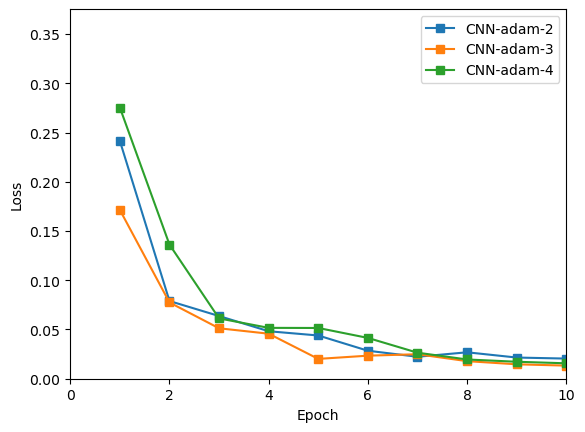

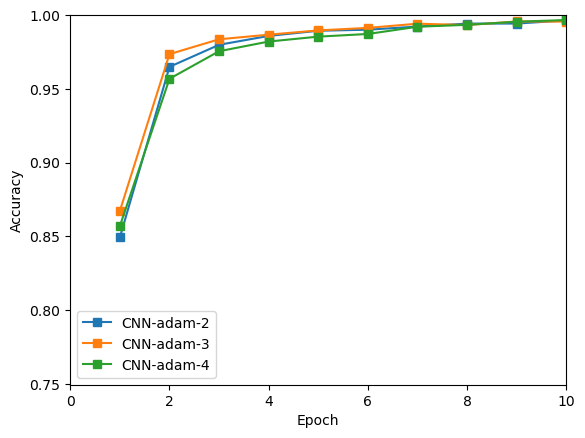

In [85]:
plot_loss_and_acc({'CNN-adam-2': [cnn_loss2, cnn_acc2],
                   'CNN-adam-3': [cnn_loss3, cnn_acc3],
                   'CNN-adam-4': [cnn_loss4, cnn_acc4],
                   })

In [86]:
# 优化器 SGD 更换优化器为SGD
# CNN 模型
cnn_model5 = ConvNet2().to(DEVICE)
optimizer5 = optim.SGD(cnn_model5.parameters(),lr=learning_rate, momentum=momentum)
cnn_model5, cnn_loss5, cnn_acc5 = train(cnn_model5, DEVICE, train_loader, optimizer5, EPOCHS)
test(cnn_model5, DEVICE, test_loader)

Train Epoch: 1 [15360/60000 (25%)]	Loss: 0.393155	ACC: 0.641211
Train Epoch: 1 [30720/60000 (50%)]	Loss: 0.128788	ACC: 0.791113
Train Epoch: 1 [46080/60000 (75%)]	Loss: 0.156664	ACC: 0.849805
Train Epoch: 2 [15360/60000 (25%)]	Loss: 0.062539	ACC: 0.978971
Train Epoch: 2 [30720/60000 (50%)]	Loss: 0.047959	ACC: 0.979883
Train Epoch: 2 [46080/60000 (75%)]	Loss: 0.058674	ACC: 0.980469
Train Epoch: 3 [15360/60000 (25%)]	Loss: 0.029614	ACC: 0.983724
Train Epoch: 3 [30720/60000 (50%)]	Loss: 0.047822	ACC: 0.985124
Train Epoch: 3 [46080/60000 (75%)]	Loss: 0.030940	ACC: 0.985525
Train Epoch: 4 [15360/60000 (25%)]	Loss: 0.070574	ACC: 0.989844
Train Epoch: 4 [30720/60000 (50%)]	Loss: 0.031557	ACC: 0.990365
Train Epoch: 4 [46080/60000 (75%)]	Loss: 0.018431	ACC: 0.989952
Train Epoch: 5 [15360/60000 (25%)]	Loss: 0.019728	ACC: 0.993229
Train Epoch: 5 [30720/60000 (50%)]	Loss: 0.033519	ACC: 0.993229
Train Epoch: 5 [46080/60000 (75%)]	Loss: 0.035114	ACC: 0.993034
Train Epoch: 6 [15360/60000 (25%)]	Loss:

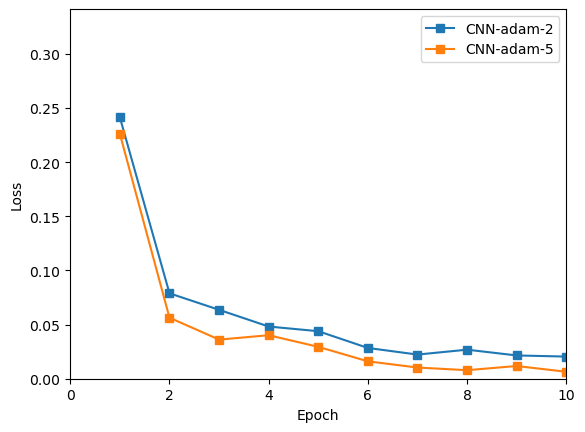

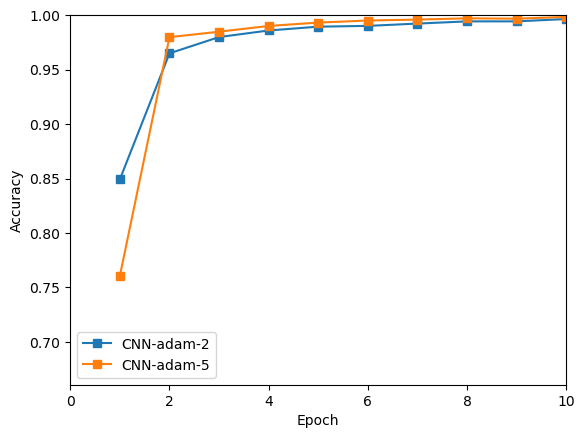

In [87]:
plot_loss_and_acc({'CNN-adam-2': [cnn_loss2, cnn_acc2],
                   'CNN-adam-5': [cnn_loss5, cnn_acc5]})